# Medicine to Market | Why Do Clinical Trials Fail?

>In order to commercialize medical treatment in the United States, the treatment must complete clinical trials. These trials cost millions of dollars and years of effort. The failure of a clinical trial to be completed not only wastes money, but also prevents potentially life-saving treatments from reaching people who need it most.

## Goal for this Notebook:
Explore various reasons why clinical trials are not completed.

## Major Areas of Research:
* Study Types
* Phases
* Sources
* Number of Arms
* Number of Groups
* Intevention Types
* Sponsors
* Facilities
* State
* Number of Patients
* Interventions MeSH Categories
* Indications MeSH Categories

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import psycopg2 as pg
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn import metrics, cross_validation
from sklearn import datasets, svm
from sklearn.model_selection import train_test_split

import warnings; warnings.simplefilter('ignore')

condition_dict=pickle.load( open( "mesh_conditions.p", "rb" ) )
intervention_dict=pickle.load( open( "mesh_interventions.p", "rb" ) )

## Data Wrangling

In [2]:
connection=pg.connect("dbname=db user=user")

In [3]:
q_studies="""select studies.nct_id, 
                studies.overall_status,
                studies.study_type,
                studies.phase,
                studies.source,
                studies.number_of_arms,
                studies.number_of_groups
            from studies
            where (studies.overall_status like '%Completed%' or studies.overall_status like '%Terminated%')
            ;
"""

df_studies=pd.read_sql(q_studies, con=connection)
df_studies['overall_status'] = (df_studies['overall_status'] !='Terminated').astype(int)

In [4]:
q_sponsor="""select studies.nct_id,
                studies.overall_status,
                sponsors.name,
                sponsors.lead_or_collaborator
            from (sponsors inner join studies on sponsors.nct_id=studies.nct_id)
            where (studies.overall_status like '%Completed%' or 
                studies.overall_status like '%Terminated%') and
                (sponsors.lead_or_collaborator like '%lead%');
                
"""
df_sponsor=pd.read_sql(q_sponsor, con=connection)
df_sponsor['overall_status'] = (df_sponsor['overall_status'] !='Terminated').astype(int)

In [6]:
q_ivn_type="""select studies.nct_id,
        studies.overall_status,
        interventions.intervention_type 
    from (interventions left join studies on interventions.nct_id=studies.nct_id) 
    where (studies.overall_status like '%Completed%' or studies.overall_status like '%Terminated%');
"""

df_ivn_type=pd.read_sql(q_ivn_type, con=connection)
df_ivn_type['overall_status'] = (df_ivn_type['overall_status'] !='Terminated').astype(int)

In [9]:
q_fac_num="""select facilities.nct_id, count(facilities.nct_id)  
        from facilities group by nct_id;"""
df_fac_num=pd.read_sql(q_fac_num, con=connection)

In [11]:
q_fac_unique="""select distinct on (facilities.nct_id)
            facilities.nct_id,
            facilities.name,
            facilities.country,
            facilities.state
            from facilities;"""

df_fac_unique=pd.read_sql(q_fac_unique, con=connection)

In [10]:
q_basecounts="""select distinct on (studies.nct_id)
    studies.nct_id,
    studies.overall_status,
    baseline_counts.count
    from
        studies
    inner join baseline_counts on studies.nct_id=baseline_counts.nct_id
    where (studies.overall_status like '%Completed%' or studies.overall_status like '%Terminated%')
    order by studies.nct_id, baseline_counts.ctgov_group_code desc
    ;"""

df_basecounts=pd.read_sql(q_basecounts, con=connection)
df_basecounts['overall_status'] = (df_basecounts['overall_status'] !='Terminated').astype(int)

In [12]:
q_mesh_con="""select studies.nct_id, 
            studies.overall_status,
            browse_conditions.mesh_term
        from (browse_conditions inner join studies on browse_conditions.nct_id=studies.nct_id)
        where (studies.overall_status like '%Completed%' or studies.overall_status like '%Terminated%');
"""

df_mesh_con=pd.read_sql(q_mesh_con, con=connection)
df_mesh_con['overall_status'] = (df_mesh_con['overall_status'] !='Terminated').astype(int)
df_mesh_con.describe()

mesh_cat=[]
for row in df_mesh_con['mesh_term']:
        if row in condition_dict:
            mesh_cat.append(condition_dict[row])
        else:
            #mesh_cat.append(row) # keeps terms not in greater categories separate
            mesh_cat.append('Other')

df_mesh_con['mesh_cat']=pd.Series(mesh_cat, index=df_mesh_con.index)

df_mesh_copy=df_mesh_con.copy()
df_mesh_copy_dropmt=df_mesh_copy.drop('mesh_term',1)
df_mesh_nodups=df_mesh_copy_dropmt.drop_duplicates()

In [13]:
q_mesh_ivn="""select studies.nct_id,
            studies.overall_status,
            browse_interventions.mesh_term
        from (browse_interventions inner join studies on browse_interventions.nct_id=studies.nct_id)
        where (studies.overall_status like '%Completed%' or studies.overall_status like '%Terminated%');
"""

df_mesh_ivn=pd.read_sql(q_mesh_ivn, con=connection)
df_mesh_ivn['overall_status'] = (df_mesh_ivn['overall_status'] !='Terminated').astype(int)
df_mesh_ivn.describe()

mesh_ivn=[]
for row in df_mesh_ivn['mesh_term']:
        if row in intervention_dict:
            mesh_ivn.append(intervention_dict[row])
        else:
            #mesh_cat.append(row) # keeps terms not in greater categories separate
            mesh_ivn.append('Other')

df_mesh_ivn['mesh_ivn']=pd.Series(mesh_ivn, index=df_mesh_ivn.index)

# df_mesh_ivn.head()
df_ivn_copy=df_mesh_ivn.copy()
df_ivn_copy_dropmt=df_ivn_copy.drop('mesh_term',1)
df_ivn_nodups=df_ivn_copy_dropmt.drop_duplicates()

In [18]:
df_stud_spon=pd.merge(df_studies, df_sponsor, how='left', on='nct_id')
df_stud_spon_trim=df_stud_spon.drop(['overall_status_y','lead_or_collaborator'], 1)

df_ss_ivn=pd.merge(df_stud_spon_trim, df_ivn_type, how='left', on='nct_id')
df_ss_ivn_trim=df_ss_ivn.drop('overall_status',1)

df_ssi_fac_num=pd.merge(df_ss_ivn_trim, df_fac_num, how='left', on='nct_id')

df_ssif_fac_unique=pd.merge(df_ssi_fac_num, df_fac_unique, how='left', on='nct_id')

df_ssiff_basecounts=pd.merge(df_ssif_fac_unique, df_basecounts, how='left', on='nct_id')
df_ssiff_basecounts_trim=df_ssiff_basecounts.drop('overall_status',1)

df_ssiffb_mesh_con=pd.merge(df_ssiff_basecounts_trim, df_mesh_nodups, how='left', on='nct_id')
df_ssiffb_mesh_con_trim=df_ssiffb_mesh_con.drop('overall_status',1)

df_ssiffbc_mesh_ivn=pd.merge(df_ssiffb_mesh_con_trim, df_ivn_nodups, how='left', on='nct_id')
df_ssiffbci=df_ssiffbc_mesh_ivn.drop('overall_status',1)

df_comb=df_ssiffbci.rename(columns={'overall_status_x':'overall_status'})

In [20]:
df_all=df_comb.copy()
df_all['name_x'].replace(np.nan, 'Not Reported', inplace=True)
df_all['intervention_type'].replace(np.nan, 'Not Reported', inplace=True)
df_all['name_y'].replace(np.nan, 'Not Reported', inplace=True)
df_all['country'].replace(np.nan, 'Not Reported', inplace=True)
df_all['state'].replace(np.nan, 'Not Reported', inplace=True)
df_all['mesh_cat'].replace(np.nan, 'Not Reported', inplace=True)
df_all['mesh_ivn'].replace(np.nan, 'Not Reported', inplace=True)

df_all_fillna=df_all.fillna(0)

df_ivn_only_pre=df_all_fillna.copy()

df_ivn_only_pre2=df_ivn_only_pre[df_ivn_only_pre['study_type']=='Interventional']

df_ivn_only=df_ivn_only_pre2.drop('nct_id',1)

## Fun Facts

### Cancer and Other Neoplasms studies have the greatest number of terminated clinical trials.

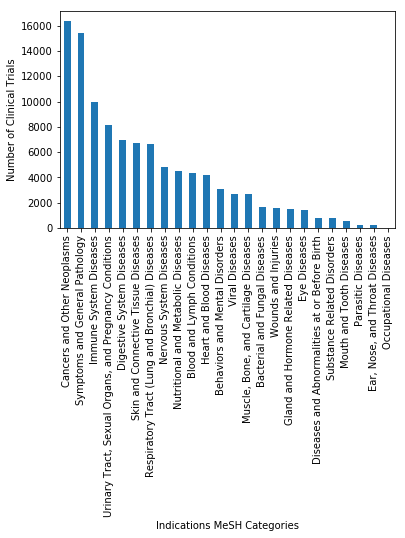

In [27]:
df_fig1_pre=df_ivn_only.loc[:,['overall_status','mesh_cat']]
df_fig1=df_fig1_pre.groupby(['mesh_cat','overall_status'])['mesh_cat'].count().unstack().fillna(0)

term_trials_pre=df_fig1[0].drop('Not Reported')
term_trials=term_trials_pre.drop('Other')
ax = term_trials.sort_values(ascending=False).plot(kind='bar')
ax.set_ylabel("Number of Clinical Trials")
ax.set_xlabel("Indications MeSH Categories")

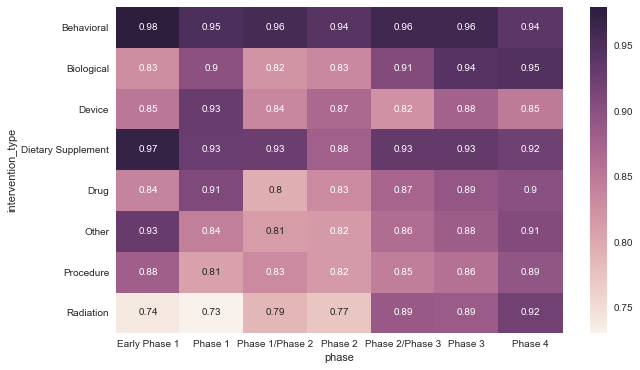

In [70]:
df_fig2_pre=df_ivn_only.loc[:,['overall_status','phase', 'intervention_type']]
df_fig2_pre2=df_fig2_pre.copy()
df_fig2_pre3=df_fig2_pre2[df_fig2_pre2['phase'] != 'N/A']
df_fig2_pre4=df_fig2_pre3[df_fig2_pre2['intervention_type'] != 'Not Reported']
df_fig2_pre5=df_fig2_pre4[df_fig2_pre2['intervention_type'] != 'Combination Product']
df_fig2_pre6=df_fig2_pre5[df_fig2_pre2['intervention_type'] != 'Diagnostic Test']
df_fig2_pre7=df_fig2_pre6[df_fig2_pre2['intervention_type'] != 'Genetic']

phase_ivn_type_pivot=pd.pivot_table(df_fig2_pre7, values='overall_status', index='intervention_type', columns='phase', aggfunc=np.mean)

plt.figure(figsize=(10, 6))
sns.heatmap(phase_ivn_type_pivot, annot=True)

### Clinical Trials in Early Phase I and involving some sort of Phase 2 are most likely to terminate.

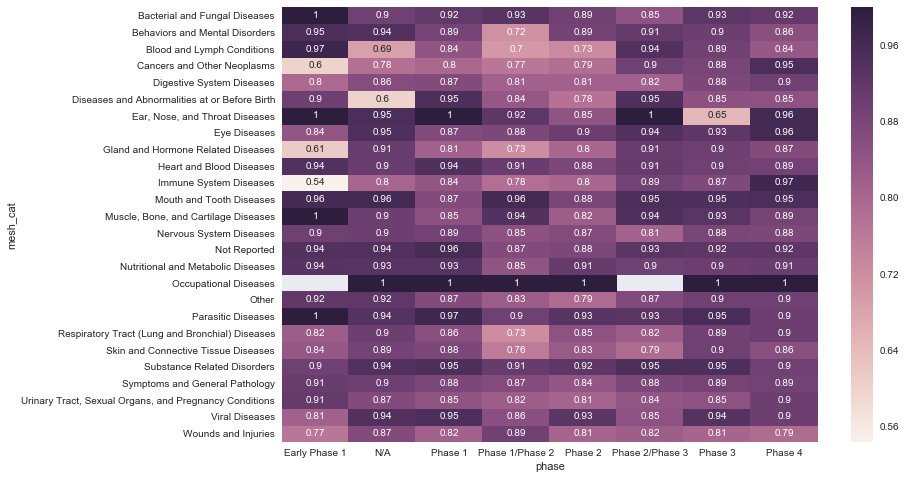

In [71]:
df_fig2a_pre=df_ivn_only.loc[:,['overall_status','phase', 'mesh_cat']]
df_fig2a_pre2=df_fig2a_pre.copy()
df_fig2a_pre3=df_fig2a_pre2[df_fig2a_pre2['phase'] != 'N/A']

# df_fig2a_pre4=df_fig2a_pre3[df_fig2a_pre2['intervention_type'] != 'Not Reported']
# df_fig2a_pre5=df_fig2a_pre4[df_fig2a_pre2['intervention_type'] != 'Combination Product']
# df_fig2a_pre6=df_fig2a_pre5[df_fig2a_pre2['intervention_type'] != 'Diagnostic Test']
# df_fig2a_pre7=df_fig2a_pre6[df_fig2a_pre2['intervention_type'] != 'Genetic']

phase_mesh_cat_type_pivot=pd.pivot_table(df_fig2a_pre2, values='overall_status', index='mesh_cat', columns='phase', aggfunc=np.mean)

plt.figure(figsize=(12, 8))
sns.heatmap(phase_mesh_cat_type_pivot, annot=True)

In [37]:
df_fig3_pre=df_ivn_only.loc[:,['overall_status','name_x']]

In [44]:
df_fig3=df_fig3_pre.groupby(['name_x','overall_status'])['name_x'].count().unstack().fillna(0)
df_fig3_sum=(df_fig3[0]+df_fig3[1])
df_fig3_avg=(df_fig3[1]/(df_fig3[0]+df_fig3[1]))
df_fig3['sum']=df_fig3_sum
df_fig3['avg']=df_fig3_avg
df_fig3_gt500=df_fig3[df_fig3['sum']>500].sort_values('avg', ascending=False)

### 10 sponsors have completed all of their clinical trials (having attempted at least 500 trials).

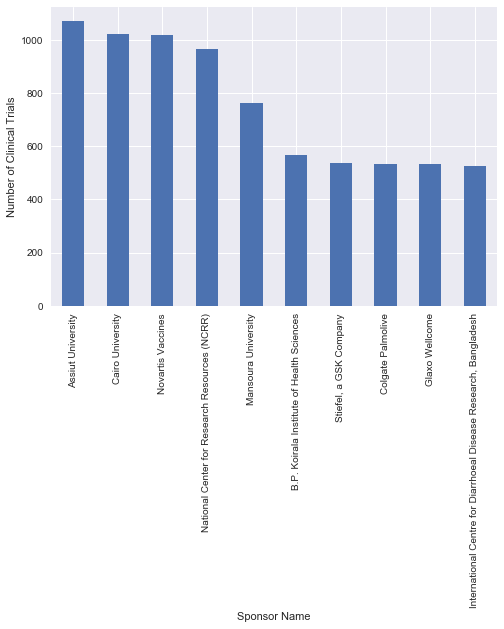

In [66]:
ax=df_fig3_gt500.head(10).sort_values('sum', ascending=False)['sum'].plot(kind='bar')
ax.set_ylabel("Number of Clinical Trials")
ax.set_xlabel("Sponsor Name")

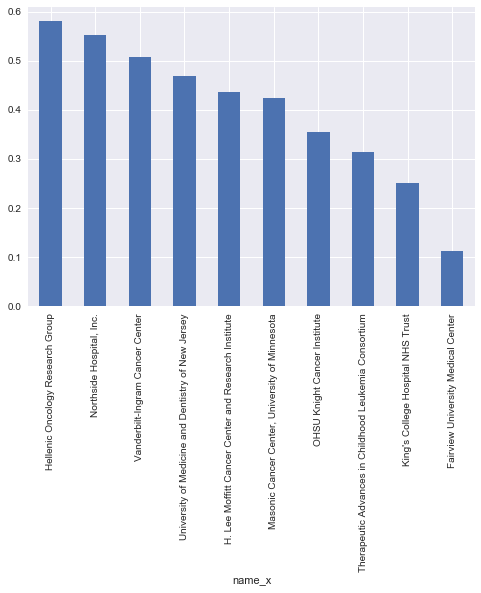

In [64]:
df_fig3_gt500.tail(10).sort_values('avg', ascending=False)['avg'].plot(kind='bar')

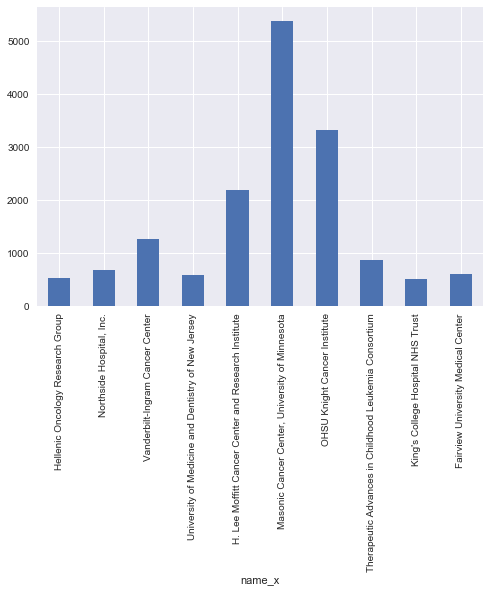

In [68]:
df_fig3_gt500.tail(10).sort_values('avg', ascending=False)['sum'].plot(kind='bar')